# 주택 가격 예측하기
## 1. 데이터 준비하기
- Keras에 기본 포함된 1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율과 이에 따른 주택 가격의 데이터를 바탕으로 주택 가격을 예측하는 회귀 모델을 구축해 본다.
- 훈련 샘플 404개와 테스트 샘플 104개로 비교적 데이터 포인트의 개수가 적다.

In [20]:
from tensorflow.keras.datasets import boston_housing
import tensorflow as tf

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

- 입력 데이터에 있는 각 특성은 스케일이 서로 다르다.
- 어떤 값은 0 ~ 1 까지의 비율을 나타내고 어떤 것은 1 과 100 사이의 값을 나타내기도 한다.

In [21]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

- 서로 다른 스케일의 특성들은 신경망에서 잘못 해석될 수 있으므로, 정규화를 진행한다.
- 훈련 단계에서는 절대로 테스트 데이터의 특성을 반영하면 안 되기 때문에, 훈련 데이터의 특성으로만 정규화를 진행한다.

In [22]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 2. 모델 생성 및 훈련
- 이 모델은 새로운 값을 예측하는 회귀 모델이기 때문에, 여러 겹의 Dense 층 아래 마지막 층은 1개의 파라미터를 갖는다.
- 회귀 문제에서 흔하게 사용되는 손실 함수인 mean squared error 를 사용한다.
- 데이터 포인트의 수가 적기 때문에 K-겹 교차 검증을 통해 여러번 모델을 훈련시켜 더 균일한 모델을 만들 수 있도록 한다.

In [25]:
from keras import models, layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

In [10]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 20
all_scores = []

for i in range(k):
    print('Processing fold #', i)
    val_data = train_data[i * num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]],
    axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [29]:
print(all_scores)
print(np.mean(all_scores))

[2.0478169918060303, 2.716521978378296, 2.604544162750244, 2.552786111831665]
2.480417311191559


- 데이터가 적기 때문에 K개의 검증 세트의 정확도가 꽤 많이 나게 되므로 평균값을 구한다.
- 주택 가격 데이터의 단위는 천 달러이므로 검증 데이터에 대해 평균적으로 2,500 달러라는 적지 않은 차이가 나게 된다.
- 각 세트의 검증 정확도를 확인하기 위해 검증 정확도를 기록하도록 하여 다시 훈련시킨다.

In [39]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('Processing fold #', i)
    val_data = train_data[i * num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]],
    axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [41]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

- 훈련 과정에서 얻은 각 세트별 검증 정확도의 평균을 구하여 epoch당 어떻게 변화하는지 살펴보자.

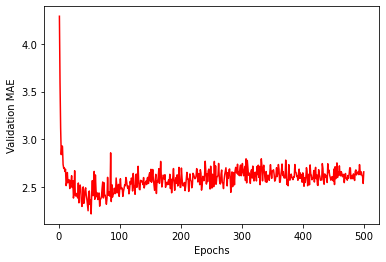

In [43]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

- 데이터의 범위가 매우 크고 변동이 심해서 보기 어려우므로 첫 부분의 데이터를 없애고 지수 이동 평균을 활용하여 곡선을 더 부드럽게 만든다.

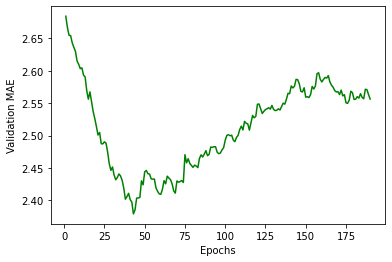

In [55]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smoothed_mae_history = smooth_curve(average_mae_history[10:200])

plt.clf()
plt.plot(range(1, len(smoothed_mae_history) + 1), smoothed_mae_history, 'g')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show() 

- 그래프를 보면 약 80번째 epoch 이후에는 검증 정확도가 감소하지 않고 오히려 증가하는 경향이 보인다.
- Overfitting을 막기 위해 epoch 횟수를 재조정하고 다시 훈련시킨 후 테스트 데이터로 모델의 정확도를 확인한다.

In [56]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=2)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/80
26/26 - 1s - loss: 477.9825 - mean_absolute_error: 19.8793 - 514ms/epoch - 20ms/step
Epoch 2/80
26/26 - 0s - loss: 280.7557 - mean_absolute_error: 14.6647 - 122ms/epoch - 5ms/step
Epoch 3/80
26/26 - 0s - loss: 117.4607 - mean_absolute_error: 8.5484 - 121ms/epoch - 5ms/step
Epoch 4/80
26/26 - 0s - loss: 53.8014 - mean_absolute_error: 5.4498 - 121ms/epoch - 5ms/step
Epoch 5/80
26/26 - 0s - loss: 35.9917 - mean_absolute_error: 4.2803 - 137ms/epoch - 5ms/step
Epoch 6/80
26/26 - 0s - loss: 28.6128 - mean_absolute_error: 3.7923 - 150ms/epoch - 6ms/step
Epoch 7/80
26/26 - 0s - loss: 24.7160 - mean_absolute_error: 3.4878 - 117ms/epoch - 4ms/step
Epoch 8/80
26/26 - 0s - loss: 21.5944 - mean_absolute_error: 3.2714 - 126ms/epoch - 5ms/step
Epoch 9/80
26/26 - 0s - loss: 18.9377 - mean_absolute_error: 3.0184 - 128ms/epoch - 5ms/step
Epoch 10/80
26/26 - 0s - loss: 16.6590 - mean_absolute_error: 2.8351 - 121ms/epoch - 5ms/step
Epoch 11/80
26/26 - 0s - loss: 14.9715 - mean_absolute_error: 2

In [58]:
print("mse:", test_mse_score, "mae:", test_mae_score)

mse: 17.3492374420166 mae: 2.604771137237549
